# TensorFlow_LowerLevel_API_Graph_and_Session
xiangjl xjliww@163.com 2018/10/18

文章参考：https://tensorflow.google.cn/programmers_guide/graphs

In [ ]:
import tensorflow as tf
import numpy as nm

TensorFlow 使用数据流图将计算表示为独立的指令之间的依赖关系。这可生成低级别的编程模型，在该模型中，您首先定义数据流图，然后创建 TensorFlow 会话，以便在一组本地和远程设备上运行图的各个部分。

如果您计划直接使用低级别编程模型，本指南将是您最实用的参考资源。较高阶的 API（例如 tf.estimator.Estimator 和 Keras）会向最终用户隐去图和会话的细节内容，但如果您希望理解这些 API 的实现方式，本指南仍会对您有所帮助。

## 1 为什么使用数据流图？

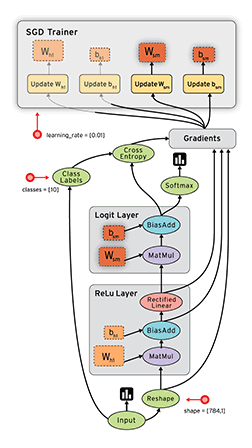

数据流是一种用于并行计算的常用编程模型。在数据流图中，节点表示计算单元，边缘表示计算使用或产生的数据。例如，在 TensorFlow 图中，tf.matmul 操作对应单个节点，该节点具有两个传入边缘（要相乘的矩阵）和一个传出边缘（乘法结果）。

在执行您的程序时，数据流可以为 TensorFlow 提供多项优势：

    并行处理。 通过使用明确的边缘来表示操作之间的依赖关系，系统可以轻松识别能够并行执行的操作。

    分布式执行。 通过使用明确的边缘来表示操作之间流动的值，TensorFlow 可以将您的程序划分到连接至不同机器的多台设备上（CPU、GPU 和 TPU）。TensorFlow 将在这些设备之间进行必要的通信和协调。

    编译。 TensorFlow 的 XLA 编译器可以使用数据流图中的信息生成更快的代码，例如将相邻的操作融合到一起。

    可移植性。 数据流图是一种不依赖于语言的模型代码表示法。您可以使用 Python 构建数据流图，将其存储在 SavedModel 中，并使用 C++ 程序进行恢复，从而实现低延迟的推理。


## 2 什么是 tf.Graph？

tf.Graph 包含两类相关信息：

    图结构。 图的节点和边缘，表示各个操作组合在一起的方式，但不规定它们的使用方式。图结构与汇编代码类似：检查图结构可以传达一些有用的信息，但它不包含源代码传达的所有实用上下文信息。

    图集合。 TensorFlow 提供了一种在 tf.Graph 中存储元数据集合的通用机制。tf.add_to_collection 函数允许您将对象列表与一个键关联（其中 tf.GraphKeys 定义了部分标准键），tf.get_collection 允许您查询与某个键关联的所有对象。TensorFlow 库的许多部分会使用此设施资源：例如，当您创建 tf.Variable 时，系统会默认将其添加到表示“全局变量”和“可训练变量”的集合中。当您后续创建 tf.train.Saver 或 tf.train.Optimizer 时，这些集合中的变量将用作默认参数。

## 3 构建 tf.Graph

大多数 TensorFlow 程序都以数据流图构建阶段开始。在此阶段，您会调用 TensorFlow API 函数，这些函数可构建新的 tf.Operation（节点）和 tf.Tensor（边缘）对象并将它们添加到 tf.Graph 实例中。TensorFlow 提供了一个默认图，此图是同一上下文中的所有 API 函数的明确参数。例如：

    调用 tf.constant(42.0) 可创建单个 tf.Operation，该操作可以生成值 42.0，将该值添加到默认图中，并返回表示常量值的 tf.Tensor。

    调用 tf.matmul(x, y) 可创建单个 tf.Operation，该操作会将 tf.Tensor 对象 x 和 y 的值相乘，将其添加到默认图中，并返回表示乘法运算结果的 tf.Tensor。

    执行 v = tf.Variable(0) 可向图添加一个 tf.Operation，该操作可以存储一个可写入的张量值，该值在多个 tf.Session.run 调用之间保持恒定。tf.Variable 对象会封装此操作，并可以像张量一样使用，即读取已存储的值的当前值。tf.Variable 对象也具有 assign 和 assign_add 等方法，这些方法可创建 tf.Operation 对象，这些对象在执行时将更新已存储的值。（请参阅变量了解关于变量的更多信息。）

    调用 tf.train.Optimizer.minimize 可将操作和张量添加到计算梯度的默认图中，并返回一个 tf.Operation，该操作在运行时会将这些梯度应用到一组变量上。

大多数程序仅依赖于默认图。尽管如此，请参阅处理多个图了解更加高级的用例。高阶 API（比如 tf.estimator.Estimator API）可替您管理默认图，并且还具有其他功能，例如创建不同的图以用于训练和评估。

## 4 命名指令

tf.Graph 对象会为其包含的 tf.Operation 对象定义一个命名空间。TensorFlow 会自动为您的图中的每个指令选择一个唯一名称，但您也可以指定描述性名称，使您的程序阅读和调试起来更轻松。TensorFlow API 提供两种方法来覆盖操作名称：

    如果 API 函数会创建新的 tf.Operation 或返回新的 tf.Tensor，则会接受可选 name 参数。例如，tf.constant(42.0, name="answer") 会创建一个新的 tf.Operation（名为 "answer"）并返回一个 tf.Tensor（名为 "answer:0"）。如果默认图已包含名为 "answer" 的操作，则 TensorFlow 会在名称上附加 "_1"、"_2" 等字符，以便让名称具有唯一性。

    借助 tf.name_scope 函数，您可以向在特定上下文中创建的所有操作添加名称作用域前缀。当前名称作用域前缀是一个用 "/" 分隔的名称列表，其中包含所有活动 tf.name_scope 上下文管理器的名称。如果某个名称作用域已在当前上下文中被占用，TensorFlow 将在该作用域上附加 "_1"、"_2" 等字符。例如

In [ ]:
c_0 = tf.constant(0, name="c")  # => operation named "c"

# Already-used names will be "uniquified".
c_1 = tf.constant(2, name="c")  # => operation named "c_1"

# Name scopes add a prefix to all operations created in the same context.
with tf.name_scope("outer"):
  c_2 = tf.constant(2, name="c")  # => operation named "outer/c"

  # Name scopes nest like paths in a hierarchical file system.
  with tf.name_scope("inner"):
    c_3 = tf.constant(3, name="c")  # => operation named "outer/inner/c"

  # Exiting a name scope context will return to the previous prefix.
  c_4 = tf.constant(4, name="c")  # => operation named "outer/c_1"

  # Already-used name scopes will be "uniquified".
  with tf.name_scope("inner"):
    c_5 = tf.constant(5, name="c")  # => operation named "outer/inner_1/c"

图可视化工具使用名称范围来为指令分组并降低图的视觉复杂性。更多信息请参阅可视化您的图。

请注意，tf.Tensor 对象以生成输出张量的 tf.Operation 明确命名。张量名称的形式为 "<OP_NAME>:<i>"，其中：

    "<OP_NAME>" 是生成该张量的操作的名称。
    "<i>" 是一个整数，表示该张量在操作的输出中的索引。

## 5 将操作放置到不同的设备上

如果您希望 TensorFlow 程序使用多台不同的设备，则可以使用 tf.device 函数轻松地请求将在特定上下文中创建的所有操作放置到同一设备（或同一类型的设备）上。

设备规范具有以下形式：

/job:<JOB_NAME>/task:<TASK_INDEX>/device:<DEVICE_TYPE>:<DEVICE_INDEX>

其中：

    <JOB_NAME> 是一个字母数字字符串，并且不以数字开头。
    <DEVICE_TYPE> 是一种注册设备类型（例如 GPU 或 CPU）。
    <TASK_INDEX> 是一个非负整数，表示名为 <JOB_NAME> 的作业中的任务的索引。请参阅 tf.train.ClusterSpec 了解作业和任务的说明。
    <DEVICE_INDEX> 是一个非负整数，表示设备索引，例如用于区分同一进程中使用的不同 GPU 设备。

您无需指定设备规范的每个部分。例如，如果您在具有单个 GPU 的单机器配置中运行，您可以使用 tf.device 将一些操作固定到 CPU 和 GPU 上：

In [ ]:
# Operations created outside either context will run on the "best possible"
# device. For example, if you have a GPU and a CPU available, and the operation
# has a GPU implementation, TensorFlow will choose the GPU.
weights = tf.random_normal([2, 3, 4])

with tf.device("/device:CPU:0"):
  # Operations created in this context will be pinned to the CPU.
  img = tf.decode_jpeg(tf.read_file("img.jpg"))

with tf.device("/device:GPU:0"):
  # Operations created in this context will be pinned to the GPU.
  result = tf.matmul(weights, img)

如果您在典型的分布式配置中部署 TensorFlow，您可以指定作业名称和任务 ID，以便将变量放到参数服务器作业 ("/job:ps") 中的任务上，并将其他操作放置到工作器作业 ("/job:worker") 中的任务上：

In [ ]:
with tf.device("/job:ps/task:0"):
  weights_1 = tf.Variable(tf.truncated_normal([784, 100]))
  biases_1 = tf.Variable(tf.zeros([100]))

with tf.device("/job:ps/task:1"):
  weights_2 = tf.Variable(tf.truncated_normal([100, 10]))
  biases_2 = tf.Variable(tf.zeros([10]))

with tf.device("/job:worker"):
  layer_1 = tf.matmul(train_batch, weights_1) + biases_1
  layer_2 = tf.matmul(train_batch, weights_2) + biases_2

借助 tf.device，您可以高度灵活地选择单个操作或 TensorFlow 图各个区域的放置方式。在很多情况下，简单的启发法具有良好的效果。例如，tf.train.replica_device_setter API 可与 tf.device 结合使用，以针对数据并行分布式训练放置操作。例如，以下代码段展示了 tf.train.replica_device_setter 如何将不同的放置政策应用于 tf.Variable 对象和其他操作：

In [ ]:
with tf.device(tf.train.replica_device_setter(ps_tasks=3)):
  # tf.Variable objects are, by default, placed on tasks in "/job:ps" in a
  # round-robin fashion.
  w_0 = tf.Variable(...)  # placed on "/job:ps/task:0"
  b_0 = tf.Variable(...)  # placed on "/job:ps/task:1"
  w_1 = tf.Variable(...)  # placed on "/job:ps/task:2"
  b_1 = tf.Variable(...)  # placed on "/job:ps/task:0"

  input_data = tf.placeholder(tf.float32)     # placed on "/job:worker"
  layer_0 = tf.matmul(input_data, w_0) + b_0  # placed on "/job:worker"
  layer_1 = tf.matmul(layer_0, w_1) + b_1     # placed on "/job:worker"

## 6 类似于张量的对象

许多 TensorFlow 操作都会接受一个或多个 tf.Tensor 对象作为参数。例如，tf.matmul 接受两个 tf.Tensor 对象，tf.add_n 接受一个具有 n 个 tf.Tensor 对象的列表。为了方便起见，这些函数将接受类张量对象来取代 tf.Tensor，并将它明确转换为 tf.Tensor（通过 tf.convert_to_tensor 方法）。类张量对象包括以下类型的元素：

    tf.Tensor
    tf.Variable
    numpy.ndarray
    list（以及类似于张量的对象的列表）
    标量 Python 类型：bool、float、int、str

您可以使用 tf.register_tensor_conversion_function 注册其他类张量类型。
    
***注意：默认情况下，每次您使用同一个类张量对象时，TensorFlow 将创建新的 tf.Tensor。如果类张量对象很大（例如包含一组训练样本的 numpy.ndarray），且您多次使用该对象，则可能会耗尽内存。要避免出现此问题，请在类张量对象上手动调用 tf.convert_to_tensor 一次，并使用返回的 tf.Tensor。

## 7 在以下会话中执行图：tf.Session

TensorFlow 使用 tf.Session 类来表示客户端程序（通常为 Python 程序，但也提供了其他语言的类似接口）与 C++ 运行时之间的连接。tf.Session 对象使我们能够访问本地机器中的设备和使用分布式 TensorFlow 运行时的远程设备。它还可缓存关于 tf.Graph 的信息，使您能够多次高效地运行同一计算。

### 7.1 创建 tf.Session

如果您使用的是低阶 TensorFlow API，您可以为当前默认图创建一个 tf.Session，如下所示：

#Create a default in-process session.
with tf.Session() as sess:
  #...

#Create a remote session.
with tf.Session("grpc://example.org:2222"):
  #...

由于 tf.Session 拥有物理资源（例如 GPU 和网络连接），因此通常（在 with 代码块中）用作上下文管理器，并在您退出代码块时自动关闭会话。您也可以在不使用 with 代码块的情况下创建会话，但应在完成会话时明确调用 tf.Session.close 以便释放资源。

***注意：较高阶的 API（例如 tf.train.MonitoredTrainingSession 或 tf.estimator.Estimator）将为您创建和管理 tf.Session。这些 API 接受可选的 target 和 config 参数（直接接受，或作为 tf.estimator.RunConfig 对象的一部分），并具有相同的含义，如下所示。

tf.Session.init 接受三个可选参数：

    target。 如果将此参数留空（默认设置），会话将仅使用本地机器中的设备。但是，您也可以指定 grpc:// 网址，以便指定 TensorFlow 服务器的地址，这使得会话可以访问该服务器控制的机器上的所有设备。请参阅 tf.train.Server 详细了解如何创建 TensorFlow 服务器。例如，在常见的图间复制配置中，tf.Session 连接到 tf.train.Server 的流程与客户端相同。分布式 TensorFlow 部署指南介绍了其他常见情形。

    graph。 默认情况下，新的 tf.Session 将绑定到当前的默认图，并且仅能够在当前的默认图中运行操作。如果您在程序中使用了多个图（更多详情请参阅使用多个图进行编程），则可以在构建会话时指定明确的 tf.Graph。

    config。 此参数允许您指定一个控制会话行为的 tf.ConfigProto。例如，部分配置选项包括：

        allow_soft_placement。将此参数设置为 True 可启用“软”设备放置算法，该算法会忽略尝试将仅限 CPU 的操作分配到 GPU 设备上的 tf.device 注解，并将这些操作放置到 CPU 上。

        cluster_def。使用分布式 TensorFlow 时，此选项允许您指定要在计算中使用的机器，并提供作业名称、任务索引和网络地址之间的映射。详情请参阅 tf.train.ClusterSpec.as_cluster_def。

        graph_options.optimizer_options。在执行图之前使您能够控制 TensorFlow 对图实施的优化。

        gpu_options.allow_growth。将此参数设置为 True 可更改 GPU 内存分配器，使该分配器逐渐增加分配的内存量，而不是在启动时分配掉大多数内存。


### 7.2 使用 tf.Session.run 执行操作

tf.Session.run 方法是运行 tf.Operation 或评估 tf.Tensor 的主要机制。您可以将一个或多个 tf.Operation 或 tf.Tensor 对象传递到 tf.Session.run，TensorFlow 将执行计算结果所需的操作。

tf.Session.run 要求您指定一组 fetch，这些 fetch 可确定返回值，并且可能是 tf.Operation、tf.Tensor 或类张量类型，例如 tf.Variable。这些 fetch 决定了必须执行整体 tf.Graph 的哪些子图以生成结果：该子图包含 fetch 列表中指定的所有操作，以及其输出用于计算 fetch 值的所有操作。例如，以下代码段说明了 tf.Session.run 的不同参数如何导致执行不同的子图：

In [ ]:
x = tf.constant([[37.0, -23.0], [1.0, 4.0]])
w = tf.Variable(tf.random_uniform([2, 2]))
y = tf.matmul(x, w)
output = tf.nn.softmax(y)
init_op = w.initializer

with tf.Session() as sess:
  # Run the initializer on `w`.
  sess.run(init_op)

  # Evaluate `output`. `sess.run(output)` will return a NumPy array containing
  # the result of the computation.
  print(sess.run(output))

  # Evaluate `y` and `output`. Note that `y` will only be computed once, and its
  # result used both to return `y_val` and as an input to the `tf.nn.softmax()`
  # op. Both `y_val` and `output_val` will be NumPy arrays.
  y_val, output_val = sess.run([y, output])
  

tf.Session.run 也可以选择接受 Feed 字典，该字典是从 tf.Tensor 对象（通常是 tf.placeholder 张量）到在执行时会被替换为这些张量的值（通常是 Python 标量、列表或 NumPy 数组）的映射。例如：

In [ ]:
# Define a placeholder that expects a vector of three floating-point values,
# and a computation that depends on it.
x = tf.placeholder(tf.float32, shape=[3])
y = tf.square(x)

with tf.Session() as sess:
  # Feeding a value changes the result that is returned when you evaluate `y`.
  print(sess.run(y, {x: [1.0, 2.0, 3.0]}))  # => "[1.0, 4.0, 9.0]"
  print(sess.run(y, {x: [0.0, 0.0, 5.0]}))  # => "[0.0, 0.0, 25.0]"

  # Raises <a href="../api_docs/python/tf/errors/InvalidArgumentError"><code>tf.errors.InvalidArgumentError</code></a>, because you must feed a value for
  # a `tf.placeholder()` when evaluating a tensor that depends on it.
  sess.run(y)

  # Raises `ValueError`, because the shape of `37.0` does not match the shape
  # of placeholder `x`.
  sess.run(y, {x: 37.0})

tf.Session.run 也接受可选的 options 参数（允许您指定与调用有关的选项）和可选的 run_metadata 参数（允许您收集与执行有关的元数据）。例如，您可以同时使用这些选项来收集与执行有关的跟踪信息：

In [ ]:
y = tf.matmul([[37.0, -23.0], [1.0, 4.0]], tf.random_uniform([2, 2]))

with tf.Session() as sess:
  # Define options for the `sess.run()` call.
  options = tf.RunOptions()
  options.output_partition_graphs = True
  options.trace_level = tf.RunOptions.FULL_TRACE

  # Define a container for the returned metadata.
  metadata = tf.RunMetadata()

  sess.run(y, options=options, run_metadata=metadata)

  # Print the subgraphs that executed on each device.
  print(metadata.partition_graphs)

  # Print the timings of each operation that executed.
  print(metadata.step_stats)

## 8 直观展示您的图

TensorFlow 包含可帮助您理解图中的代码的工具。图可视化工具是 TensorBoard 的一个组件，可在浏览器中可视化图的结构。要创建可视化图表，最简单的方法是传递 tf.Graph（在创建 tf.summary.FileWriter 时）：

In [17]:
# Build your graph.
x = tf.constant([[37.0, -23.0], [1.0, 4.0]])
w = tf.Variable(tf.random_uniform([2, 2]))
y = tf.matmul(x, w)
y_ = tf.constant([[37.0, -23.0], [1.0, 4.0]])
# ...
loss = tf.reduce_mean(tf.square(y-y_))
train_op = tf.train.AdagradOptimizer(0.01).minimize(loss)

with tf.Session() as sess:
  init_op = tf.global_variables_initializer()
  sess.run(init_op)
  # `sess.graph` provides access to the graph used in a <a href="../api_docs/python/tf/Session"><code>tf.Session</code></a>.
  writer = tf.summary.FileWriter("/tmp/log/test1234", sess.graph)
  # Perform your computation...
  for i in range(1000):
    sess.run(train_op)
    # ...

  writer.close()

***注意：如果您使用的是 tf.estimator.Estimator，图（以及任何汇总）将自动记录到您在创建 Estimator 时指定的 model_dir 中。

随后，您可以在 tensorboard 中打开日志并转到“图”标签，查看图结构的概要可视化图表。请注意，典型的 TensorFlow 图（尤其是具有自动计算的梯度的训练图）包含的节点太多，无法一次性完成直观展示。图可视化工具使用名称范围来将相关指令分组到“超级”节点中。您可以点击任意超级节点上的橙色“+”按钮以展开内部的子图。

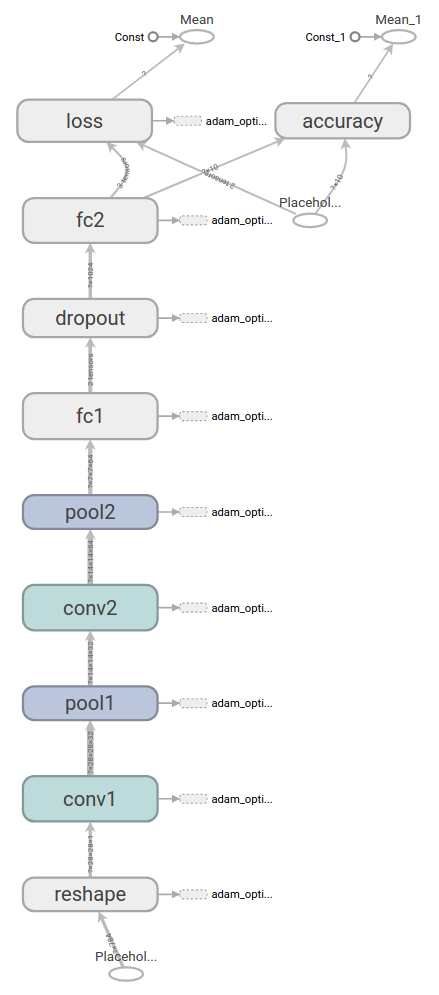

要详细了解如何使用 TensorBoard 直观展示您的 TensorFlow 应用，请参阅 TensorBoard 教程。

命令行运行:

tensorboard --logdir="..."

## 9 使用多个图进行编程

***注意：训练模型时，整理代码的一种常用方法是使用一个图训练模型，然后使用另一个图对受训模型进行评估或推理。在许多情况下，推理图与训练图不同：例如，丢弃和批次标准化等技术在每种情形下使用不同的操作。此外，默认情况下，tf.train.Saver 等实用程序使用 tf.Variable 对象的名称（此类对象的名称基于底层 tf.Operation）来识别已保存检查点中的每个变量。采用这种方式编程时，您可以使用完全独立的 Python 进程来构建和执行图，或者在同一进程中使用多个图。此部分介绍了如何在同一进程中使用多个图。

如上所述，TensorFlow 提供了一个“默认图”，此图明确传递给同一上下文中的所有 API 函数。对于许多应用而言，单个图便已足够。但是，TensorFlow 还提供了操作默认图的方法，在更高级的用例中，这些方法可能十分有用。例如：

    tf.Graph 会定义 tf.Operation 对象的命名空间：单个图中的每个操作必须具有唯一名称。如果请求的名称已被占用，TensorFlow 将在操作名称上附加 "_1"、"_2" 等字符，以便确保名称的唯一性。通过使用多个明确创建的图，您可以更有效地控制为每个操作指定什么样的名称。

    默认图会存储与添加的每个 tf.Operation 和 tf.Tensor 有关的信息。如果您的程序创建了大量未连接的子图，更有效的做法是使用另一个 tf.Graph 构建每个子图，以便回收不相关的状态。

您可以安装另一个 tf.Graph 作为默认图（使用 tf.Graph.as_default 上下文管理器）：

In [ ]:
g_1 = tf.Graph()
with g_1.as_default():
  # Operations created in this scope will be added to `g_1`.
  c = tf.constant("Node in g_1")

  # Sessions created in this scope will run operations from `g_1`.
  sess_1 = tf.Session()

g_2 = tf.Graph()
with g_2.as_default():
  # Operations created in this scope will be added to `g_2`.
  d = tf.constant("Node in g_2")

# Alternatively, you can pass a graph when constructing a <a href="../api_docs/python/tf/Session"><code>tf.Session</code></a>:
# `sess_2` will run operations from `g_2`.
sess_2 = tf.Session(graph=g_2)

assert c.graph is g_1
assert sess_1.graph is g_1

assert d.graph is g_2
assert sess_2.graph is g_2

要检查当前的默认图，请调用 tf.get_default_graph，并返回一个 tf.Graph 对象：

In [ ]:
# Print all of the operations in the default graph.
g = tf.get_default_graph()
print(g.get_operations())